## 5c. Do transitions that are upregulated have longer theta - physical distance deviations?
Not really...

In [98]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import os
import pickle
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

[2025-03-12 22:03:33,267][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-03-12 22:03:33,307][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
from spyglass.shijiegu.pairwiseDecode import merge_overlapping_ranges,removeEmptyDecode
from spyglass.shijiegu.ripple_add_replay import remove_adjacent
from spyglass.shijiegu.pairwiseDecode import replay_transitions,categorized_replay_transitions,behavior_transitions,behavior_transitions_count,findXCorrAllDays
from spyglass.shijiegu.decodeHelpers import runSessionNames

In [4]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking
from spyglass.shijiegu.changeOfMind import (find_turnaround_time, findProportion,
            find_trials, load_epoch_data_wrapper, find_direction, find_trials_animal,
            find_statescrripts)
from spyglass.shijiegu.changeOfMind_triggered import (find_triggered_animal,find_triggered_transition_animal,
    find_triggered_log_session, find_triggered_log_animal,fitLM,labels,seq1,seq2,rev1,rev2,rev3)

import statsmodels.api as sm
from spyglass.shijiegu.changeOfMind_triggered import (find_triggered_animal,
    plot_physical_vs_mental_position, parse_to_transitions, 
    find_large_position_minus_decode_trials, normalize_to_1, matrix_correlation,
    find_behavior_sum, find_transitions_sum, find_transitions, correlate_transition_deltabehavior,trials_date_session_to_dict
)
from spyglass.shijiegu.pairwiseDecode import behavior_transitions_count

[22:03:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[22:03:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[22:03:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[22:03:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [62]:
def isin_tuple(target_tuple,all_tuples):
    for item in all_tuples:
        if item == target_tuple:
            #print("Tuple found!")
            return True
    return False
    
def theta_length_by_transition_up_down(replay_trials, devs, transitions_up, transitions_down):
    # find max theta-physical distance by transitions that are behaviorally up or down modulated:
    # for each trial
    #    load state script
    #    get would have been 1
    #    if would have been 1 is in up, add to pile 1
    #    if would have been 1 is in down, add to pile 2
    
    dev_transitions_up = []
    dev_transitions_down = []
    for d in replay_trials[animal].keys():
        replay_trials_day = replay_trials[animal][d]
        dev_day = devs[animal][d]
        
        for info_ind in range(len(replay_trials_day)):
            info = replay_trials_day[info_ind]
            dev = dev_day[info_ind]
            
            d = info[0]
        
            # parse
            key={'nwb_file_name':info[0],'epoch_name':info[1]}
            log=(TrialChoice & key).fetch1('choice_reward')
            log_df=pd.DataFrame(log)
            (i,j), (i,j_wouldhave) = parse_to_transitions((info[2], info[3], log_df))
    
            if isin_tuple((i-1,j_wouldhave-1),transitions_up):
                dev_transitions_up.append(dev)
            elif isin_tuple((i-1,j_wouldhave-1),transitions_down):
                dev_transitions_down.append(dev)
    return dev_transitions_up, dev_transitions_down
        

In [87]:
from scipy.stats import permutation_test

def statistic(x, y, axis):
    #return np.mean(x) - np.mean(y)
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)



In [6]:
animal = 'Eliot'
dates_to_plot = ['20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

In [63]:
animal = 'Lewis'

dates_to_plot = ['20240105','20240106','20240107','20240108','20240109',
                 '20240110']#'20240114']#'20240115','20240116','20240117','20240118','20240119','20240120']

#dates_to_plot = ['20240115','20240116','20240117','20240118','20240119','20240120']

In [64]:
replay_trials = {}
replay_trials_non = {}
devs = {}
devs_non = {}

replay_trials[animal] = {}
replay_trials_non[animal] = {}
devs[animal] = {}
devs_non[animal] = {}

for d in dates_to_plot:
    (triggered_positions, triggered_positions_abs) = ({}, {})
    (triggered_decodes, triggered_decodes_baseoff, triggered_decodes_abs) = ({}, {}, {})
    triggered_trial_info = {}

    (triggered_positions[animal], triggered_positions_abs[animal],
     triggered_decodes[animal], triggered_decodes_baseoff[animal], triggered_decodes_abs[animal],
     triggered_trial_info[animal]) = find_triggered_animal(animal,[d],
                                                           delta_t_minus = 0,delta_t_plus = 2,
                                                           max_flag = 0, segment_only = True)

    (triggered_positions_nb, triggered_positions_abs_nb) = ({}, {})
    (triggered_decodes_nb, triggered_decodes_baseoff_nb, triggered_decodes_abs_nb) = ({}, {}, {})
    
    (triggered_positions_nb[animal], triggered_positions_abs_nb[animal],
     triggered_decodes_nb[animal], triggered_decodes_baseoff_nb[animal], triggered_decodes_abs_nb[animal],
     _) = find_triggered_animal(animal,[d], nearby = 1,
                                delta_t_minus = 2,delta_t_plus = 0.5,
                                max_flag = 0, segment_only = True)


    
    (replay_trials[animal][d], inds, devs[animal][d],
         replay_trials_non[animal][d], inds_non, devs_non[animal][d] ) = find_large_position_minus_decode_trials(
        # with theta                # without theta
                animal, triggered_trial_info, 
                triggered_positions_abs, triggered_decodes_baseoff, triggered_positions_abs_nb, triggered_decodes_baseoff_nb)
    

    


[21:03:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times
some missing position data


[21:03:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:03:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:03:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:03:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[21:03:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:03:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:03:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:03:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:03:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[21:03:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:03:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times
some missing position data
some missing position data


[21:03:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:03:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:03:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:03:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:03:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:03:43][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:04:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:04:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:04:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:04:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:04:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[21:04:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:04:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:04:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:04:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:04:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[21:04:55][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:04:56][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:04:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:04:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:05:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:05:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:05:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:05:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:05:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:05:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:05:35][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times
some missing position data


[21:05:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:05:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:05:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:05:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:05:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:06:07][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times
some missing position data


[21:06:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


some missing position data
currently investigating:
04_Rev2Session2
pos 3 valid times


[21:06:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:06:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:06:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


[21:06:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Rev2Session1
pos 1 valid times


[21:06:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Rev2Session2
pos 3 valid times


[21:06:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Rev2Session3
pos 5 valid times


[21:06:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Rev2Session4
pos 7 valid times


[21:06:16][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Rev2Session5
pos 9 valid times


### find behavior

In [10]:
P_behavior_all,xcorr_plot,xcorr25_plot,xcorr975_plot = behavior_transitions(animal,dates_to_plot)
C_behavior_all, C_behavior_reward_all = behavior_transitions_count(animal,dates_to_plot)

In [90]:
# 
if animal == "Eliot":
    transitions_up = [(1,0),(2,3),(3,1)]
    transitions_down = [(1,3),(2,0),(2,1),(3,0)]
elif animal == "Lewis":
    transitions_up = [(0,1),(1,3),(3,0)]
    transitions_down = [(0,2),(1,0),(2,1)]

In [91]:
dev_transitions_up, dev_transitions_down = theta_length_by_transition_up_down(
    replay_trials, devs, transitions_up, transitions_down)

In [92]:
#dev_transitions_up

In [93]:
len(dev_transitions_down)

Text(0.5, 1.0, 'Lewis\n would have been transition 1 \n p value: 0.228')

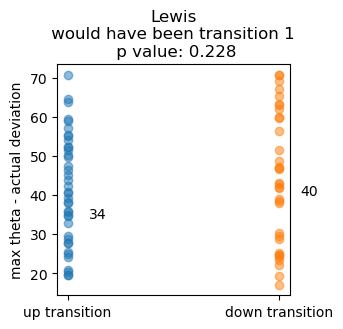

In [97]:
fig,axes = plt.subplots(1,1,figsize = (3,3),sharex = True, sharey = True)
axes.scatter(np.ones_like(dev_transitions_up),dev_transitions_up, alpha = 0.5)
axes.scatter(np.ones_like(dev_transitions_down) + 1,dev_transitions_down, alpha = 0.5)

axes.set_title(animal)
axes.set_xticks([1,2])
axes.set_ylabel("max theta - actual deviation")
axes.set_xticklabels(["up transition","down transition"])

res = permutation_test((dev_transitions_down, dev_transitions_up), statistic, vectorized=True,
                       n_resamples=10000, alternative='greater')
axes.text(1.1,len(dev_transitions_down),str(len(dev_transitions_down)))
axes.text(2.1,len(dev_transitions_up),str(len(dev_transitions_up)))

axes.set_title(animal + '\n would have been transition 1 \n p value: '+str(np.round(res.pvalue,3)))  

### End here for the section above.

## 5b. Transitions at which long-theta sequences occur.

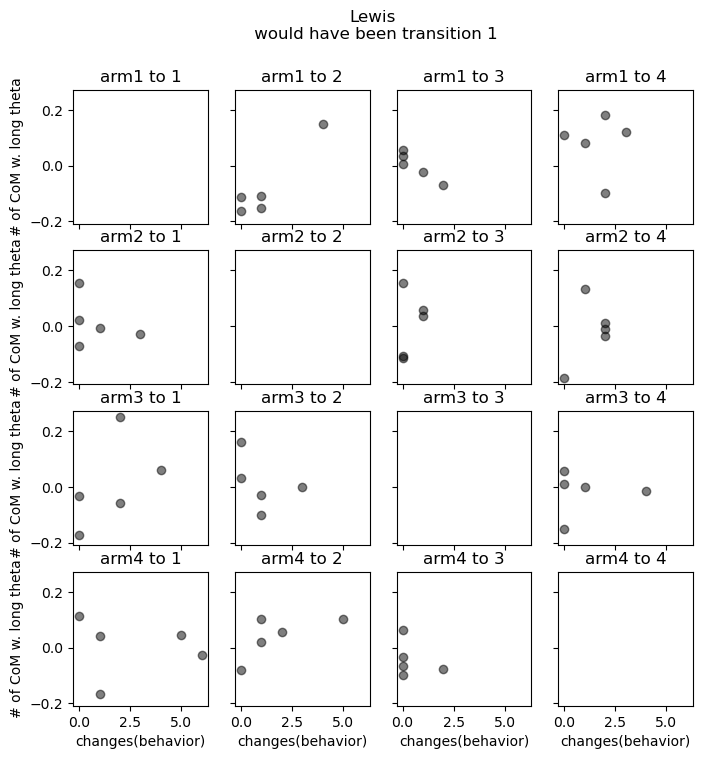

In [244]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# for aggregate plot
T_wouldhave_count1 = []
T_wouldhave_count2 = []
behavior_count = []

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))

fig,axes = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

for d_ind in range(len(dates_to_plot)-1):
    d = dates_to_plot[d_ind]
    d2 = dates_to_plot[d_ind + 1]
    if len(replay_trials[animal][d]) == 0:
        continue
    T, T_wouldhave, T_wouldhave2 = find_transitions(replay_trials[animal][d])
    delta_behavior = find_behavior_sum(animal,None,[d,d2])

    # for lumping across transitions
    behavior_count.append(delta_behavior.ravel())
    T_wouldhave_count1.append(T_wouldhave[list(T_wouldhave.keys())[0]].ravel())
    T_wouldhave_count2.append(T_wouldhave2[list(T_wouldhave2.keys())[0]].ravel())

    # for individual transitions
    for t_ind in range(len(transitions)):
        (i,j) = transitions[t_ind]
        axe_i, axe_j = (i,j)#int(np.floor(t_ind/3)), int(t_ind % 3)
        axes[axe_i, axe_j].scatter(T_wouldhave[list(T_wouldhave.keys())[0]][i,j], delta_behavior[i,j],
                                   color = 'k', alpha = 0.5)
                                  #color = cmap(norm(d_ind)))
plt.suptitle(animal + '\n would have been transition 1')    

for axe_i in range(4):
    for axe_j in range(4):
        if axe_j == 0:
            axes[axe_i, axe_j].set_ylabel("# of CoM w. long theta")
        if axe_i == 3:
            axes[axe_i, axe_j].set_xlabel("changes(behavior)")
        axes[axe_i, axe_j].set_title(f"arm{axe_i+1} to {axe_j+1}")

Text(0.5, 1.0, 'Lewis\n would have been transition 1')

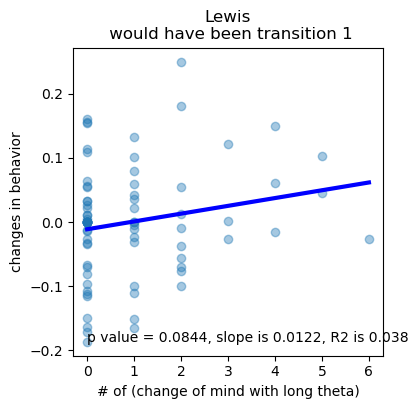

In [240]:
fig,axes = plt.subplots(1,1,figsize = (4,4),sharex = True, sharey = True)
x = np.concatenate(T_wouldhave_count1)
y = np.concatenate(behavior_count)
results, pvalue = fitLM(x,y)
    
axes.scatter(x, y, alpha = 0.4)
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
axes.plot(x_plot,y_plot,color='blue',linewidth=3,label = str(pvalue))
axes.text(np.min(x),np.min(y),
          f'p value = {np.round(pvalue_beta,4)}, slope is {np.round(results.params[1],4)}, R2 is {np.around(results.rsquared,3)}')
axes.set_xlabel("# of (change of mind with long theta)")
axes.set_ylabel("changes in behavior")

#jitter = np.random.uniform(high = 0.2, size = len(np.concatenate(T_wouldhave_count1)))
#axes.scatter(np.concatenate(T_wouldhave_count1),np.concatenate(behavior_count) > 0 + jitter, alpha = 0.4)

plt.title(animal + '\n would have been transition 1')

Text(0.5, 1.0, 'Lewis\n would have been transition 1')

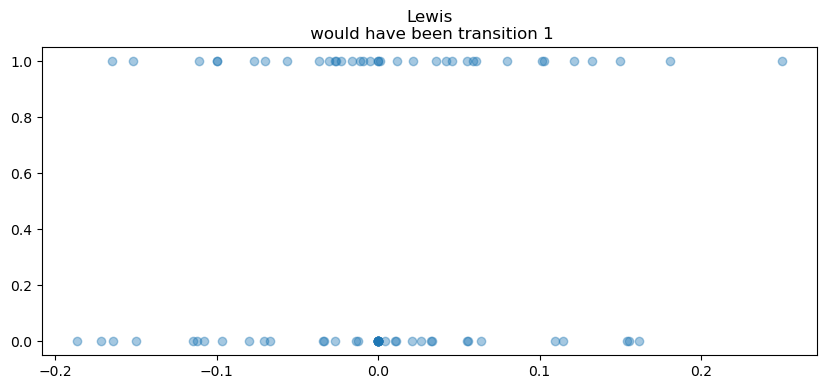

In [238]:
fig,axes = plt.subplots(1,1,figsize = (10,4),sharex = True, sharey = True)
x = np.concatenate(T_wouldhave_count1)
y = np.concatenate(behavior_count)
#results, pvalue = fitLM(x,y)
    
axes.scatter(y, x > 0, alpha = 0.4)
#x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
#y_plot=results.predict(sm.add_constant(x_plot))
#pvalue_beta = results.pvalues[1]
    
#axes.plot(x_plot,y_plot,color='blue',linewidth=3,label = str(pvalue))
#axes.text(np.min(x),np.min(y),
#          f'p value = {np.round(pvalue_beta,4)}, slope is {np.round(results.params[1],4)}, R2 is {np.around(results.rsquared,3)}')

#jitter = np.random.uniform(high = 0.2, size = len(np.concatenate(T_wouldhave_count1)))
#axes.scatter(np.concatenate(T_wouldhave_count1),np.concatenate(behavior_count) > 0 + jitter, alpha = 0.4)

plt.title(animal + '\n would have been transition 1')

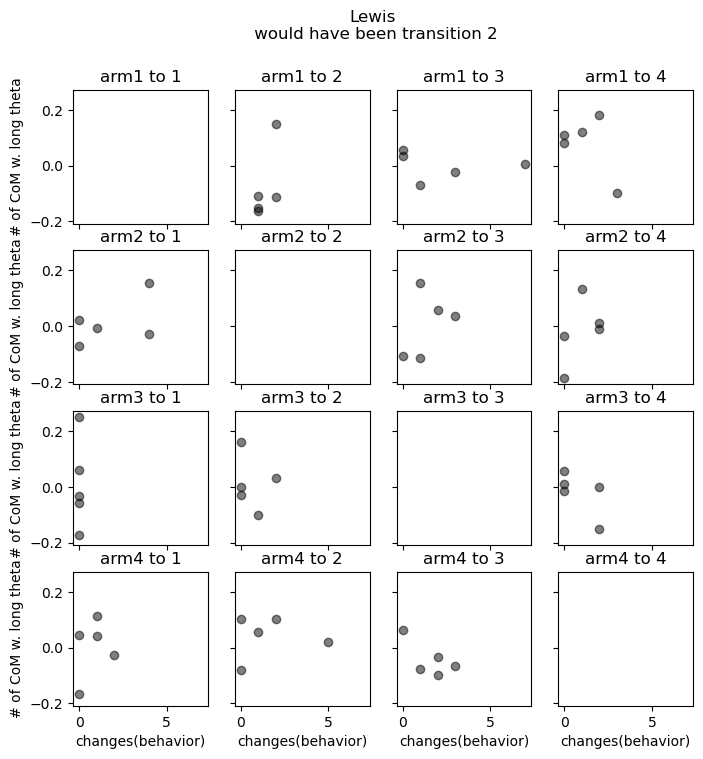

In [245]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))

fig,axes = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

for d_ind in range(len(dates_to_plot)-1):
    d = dates_to_plot[d_ind]
    d2 = dates_to_plot[d_ind + 1]
    if len(replay_trials[animal][d]) == 0:
        continue
    T, T_wouldhave, T_wouldhave2 = find_transitions(replay_trials[animal][d])
    delta_behavior = find_behavior_sum(animal,None,[d,d2])
    for t_ind in range(len(transitions)):
        (i,j) = transitions[t_ind]
        axe_i, axe_j = (i,j)#int(np.floor(t_ind/3)), int(t_ind % 3)
        axes[axe_i, axe_j].scatter(T_wouldhave2[list(T_wouldhave2.keys())[0]][i,j], delta_behavior[i,j],
                                   color = 'k', alpha = 0.5)
        
                                  #color = cmap(norm(d_ind)))
plt.suptitle(animal + '\n would have been transition 2')
for axe_i in range(4):
    for axe_j in range(4):
        if axe_j == 0:
            axes[axe_i, axe_j].set_ylabel("# of CoM w. long theta")
        if axe_i == 3:
            axes[axe_i, axe_j].set_xlabel("changes(behavior)")
        axes[axe_i, axe_j].set_title(f"arm{axe_i+1} to {axe_j+1}")

Text(0.0, -0.26344086021505375, 'p value = 0.2286, slope is -0.01, R2 is 0.011')

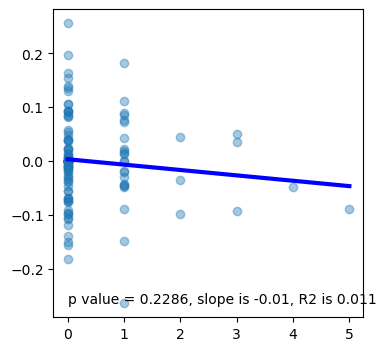

In [233]:
fig,axes = plt.subplots(1,1,figsize = (4,4),sharex = True, sharey = True)
x = np.concatenate(T_wouldhave_count2)
y = np.concatenate(behavior_count)
results, pvalue = fitLM(x,y)
    
axes.scatter(x, y, alpha = 0.4)
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
axes.plot(x_plot,y_plot,color='blue',linewidth=3,label = str(pvalue))
axes.text(np.min(x),np.min(y),
          f'p value = {np.round(pvalue_beta,4)}, slope is {np.round(results.params[1],4)}, R2 is {np.around(results.rsquared,3)}')

#jitter = np.random.uniform(high = 0.2, size = len(np.concatenate(T_wouldhave_count1)))
#axes.scatter(np.concatenate(T_wouldhave_count1),np.concatenate(behavior_count) > 0 + jitter, alpha = 0.4)